# <a id='toc1_'></a>[Bayesian Optimization with ACE](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Bayesian Optimization with ACE](#toc1_)    
  - [Notebook description](#toc1_1_)    
  - [Imports](#toc1_2_)    
  - [ACE-BO 1D](#toc1_3_)    
      - [Model loading](#toc1_3_1_1_)    
      - [Sample initial points](#toc1_3_1_2_)    
      - [ACE data and latents predictions](#toc1_3_1_3_)    
  - [ACE Thompson sampling (ACE-TS)](#toc1_4_)    
      - [$y_{opt} \sim p(y_{opt}|D)$](#toc1_4_1_1_)    
      - [$x_{opt} \sim p(x_{opt}|y_{opt},D)$](#toc1_4_1_2_)    
      - [ACE-TS Usage](#toc1_4_1_3_)    
  - [ACE Min-Value Entropy Search (ACE-MES)](#toc1_5_)    
      - [ACE-MES visualization](#toc1_5_1_1_)    
      - [ACE-MES Usage](#toc1_5_1_2_)    
  - [ACE-BO with Prior 1D](#toc1_6_)    
      - [Model loading](#toc1_6_1_1_)    
    - [ACE with Prior Thompson sampling (ACEP-TS)](#toc1_6_2_)    
      - [Flat prior](#toc1_6_2_1_)    
      - [Gaussian prior](#toc1_6_2_2_)    
    - [ACEP-TS Usage](#toc1_6_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Notebook description](#toc0_)
This notebook demonstrates how Amortized Conditioning Engine (ACE) can be applied to Bayesian Optimization (BO) tasks, using a multimodal 1D function as an illustrative example. ACE can perform direct conditioning and make predictions on the key latent variables in BO, specifically $x_{opt}$ and $y_{opt}$. Thus, ACE offers closed-form predictive distributions and samples for $p(x_{opt} \mid D_{N})$, $p(y_{opt} \mid D_{N})$, and $p(x_{opt} \mid D_{N}, y_{opt})$. By using these features, ACE offers a straightforward implementation of Thompson sampling and the Min-Value Entropy Search acquisition function in a novel, direct manner.

## <a id='toc1_2_'></a>[Imports](#toc0_)

In [1]:
import torch
from bo_demo_utils import (
    load_config_and_model,
    get_mixture_pdf,
    build_ctxtar_set,
    sample_gaussian_bin_weights,
    plot_ace_bo_1d,
    objective_function,
)
import matplotlib.pyplot as plt
import random
import numpy as np
import copy

seed = 64
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## <a id='toc1_3_'></a>[ACE-BO 1D](#toc0_)

#### <a id='toc1_3_1_1_'></a>[Model loading](#toc0_)

In [2]:
# Load model
ace_model_path = "./model/bo1d/"
_, ace_model = load_config_and_model(ace_model_path, ace_model_path + ".hydra/")

#### <a id='toc1_3_1_2_'></a>[Sample initial points](#toc0_)

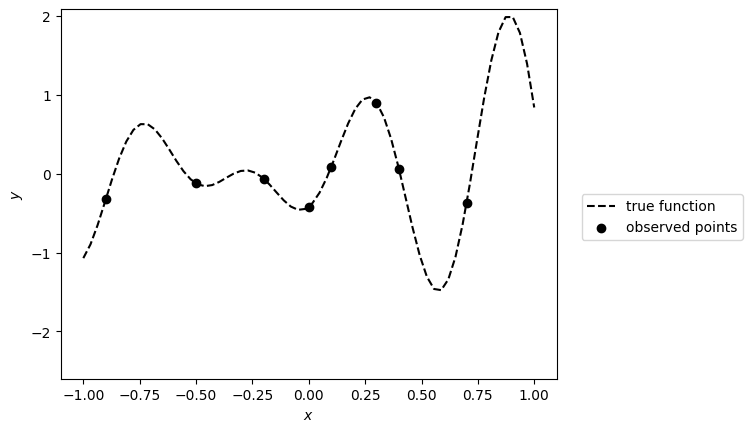

In [3]:
# Sample initial points
plot = False
n_initial = 8
dimx = 1
rangex = torch.Tensor([[-1], [1]])
use_predefined_points = True

if use_predefined_points:
    # illustrative purposes
    x = torch.Tensor([-0.9, -0.5, -0.2, 0.0, 0.1, 0.3, 0.4, 0.7])
    n_initial = len(x)
else:
    x = 2 * torch.rand(n_initial) - 1

data_autoreg = build_ctxtar_set(objective_function, x, 1)

x_true = torch.linspace(-1, 1, 64)
f_true = objective_function(x_true)

# p(y|x, D) on target set
xt_x = torch.stack((torch.ones_like(x_true), x_true), axis=-1).unsqueeze(0)
yt_y = torch.zeros_like(x_true).unsqueeze(0).unsqueeze(-1)
data_autoreg.xt = torch.concat((data_autoreg.xt, xt_x), axis=1)
data_autoreg.yt = torch.concat((data_autoreg.yt, yt_y), axis=1)

plot_ace_bo_1d(x_true, f_true, data_autoreg)

#### <a id='toc1_3_1_3_'></a>[ACE data and latents predictions](#toc0_)

ACE predicts both data points and key latent variables within a BO task. Specifically, it models predictions for $y$, $x_{opt}$ and $y_{opt}$ as a mixture of Gaussians, allowing for a more expressive representation that captures the underlying uncertainty and multimodality in the BO landscape.

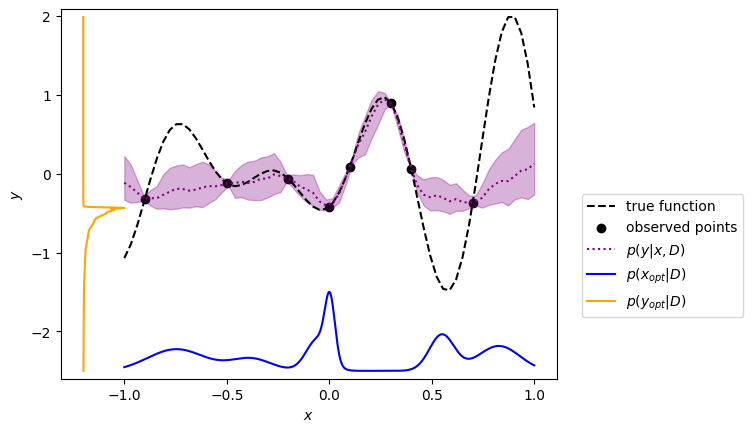

In [4]:
prediction = ace_model(data_autoreg, predict=True)

x_pdf_xopt, pdf_xopt = get_mixture_pdf(
    prediction.mixture_means[0, 0, :].detach().numpy(),
    prediction.mixture_stds[0, 0, :].detach().numpy(),
    prediction.mixture_weights[0, 0, :].detach().numpy(),
    x_range=[-1, 1],
)
x_pdf_yopt, pdf_yopt = get_mixture_pdf(
    prediction.mixture_means[0, 1, :].detach().numpy(),
    prediction.mixture_stds[0, 1, :].detach().numpy(),
    prediction.mixture_weights[0, 1, :].detach().numpy(),
    x_range=[-2.5, f_true.max()],
)

plot_ace_bo_1d(
    x_true, f_true, data_autoreg, prediction, x_pdf_xopt, pdf_xopt, x_pdf_yopt, pdf_yopt
)

## <a id='toc1_4_'></a>[ACE Thompson sampling (ACE-TS)](#toc0_)

In this section, we present the illustrative steps for performing Thompson sampling with ACE.

#### <a id='toc1_4_1_1_'></a>[$y_{opt} \sim p(y_{opt}|D)$](#toc0_)

The first step in the ACE-TS is to sample $y_{opt}$ from $p(y_{opt} | D)$.

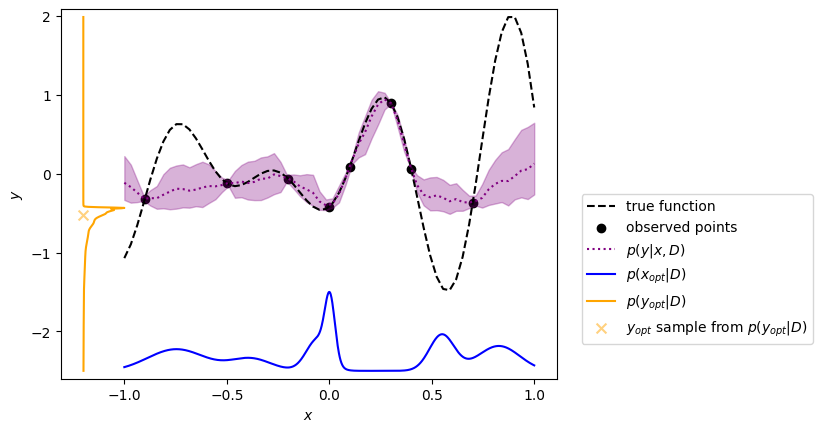

In [5]:
# get yopt sample from yopt prediction mixture
yopt_idx = random.randint(0, 1000)
yopt_sample = prediction.samples[0, 1, yopt_idx : yopt_idx + 1]

plot_ace_bo_1d(
    x_true,
    f_true,
    data_autoreg,
    prediction,
    x_pdf_xopt,
    pdf_xopt,
    x_pdf_yopt,
    pdf_yopt,
    yopt_sample,
)

#### <a id='toc1_4_1_2_'></a>[$x_{opt} \sim p(x_{opt}|y_{opt},D)$](#toc0_)

Next, we sample $x_{opt}$ by conditioning on $y_{opt}$. In practice, this involves sampling the query point at each step from the distribution $p(x_{opt} | D, y_{opt} < \tau)$, where $\tau$ is a threshold set below the minimum observed value so far. This encourages exploration by guiding the sample toward values lower than the current optimum (see Appendix C.3.2 of the paper for further details).

For illustrative purposes, we can condition on the true value of $y_{opt}$. To proceed, we add this true $y_{opt}$ value to the context set.

In [6]:
use_true_yopt = True

if use_true_yopt:
    yopt_cond = (
        -1.5
    )  # use value of the true yopt, with assumption that this value is known
else:
    yopt_cond = yopt_sample  # or you can use sampled yopt from above cell


data_autoreg_cond_yopt = copy.deepcopy(data_autoreg)

# Moving yopt from target to context (conditioning on yopt)
data_autoreg_cond_yopt.xc = torch.cat(
    (torch.Tensor([[[3, 0]]]), data_autoreg.xc), axis=1
)  # marker for yopt = 3 in 1d case
data_autoreg_cond_yopt.yc = torch.cat(
    (torch.Tensor([[[yopt_cond]]]), data_autoreg.yc), axis=1
)  # value of sampled yopt

yopt_idx_tar = 1
data_autoreg_cond_yopt.xt = torch.cat(
    (
        data_autoreg_cond_yopt.xt[:, :yopt_idx_tar, :],
        data_autoreg_cond_yopt.xt[:, yopt_idx_tar + 1 :, :],
    ),
    dim=1,
)
data_autoreg_cond_yopt.yt = torch.cat(
    (
        data_autoreg_cond_yopt.yt[:, :yopt_idx_tar, :],
        data_autoreg_cond_yopt.yt[:, yopt_idx_tar + 1 :, :],
    ),
    dim=1,
)

Notice that our $p(y|x, D)$ distributions are now shifting:

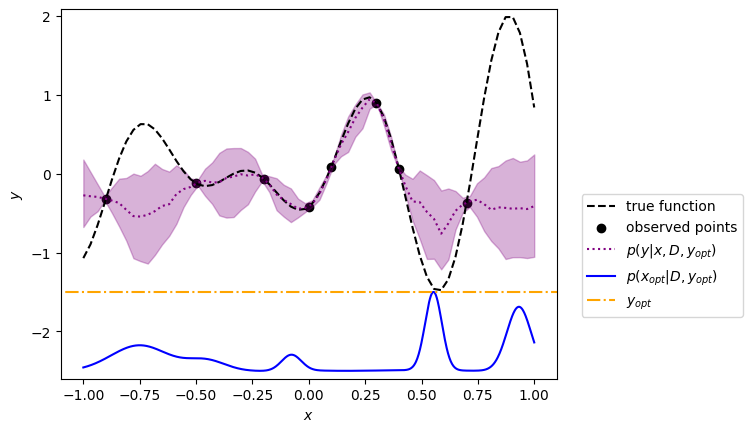

In [7]:
# prediction
prediction_cond_yopt = ace_model(data_autoreg_cond_yopt, predict=True)

x_pdf_xopt_cond_yopt, pdf_xopt_cond_yopt = get_mixture_pdf(
    prediction_cond_yopt.mixture_means[0, 0, :].detach().numpy(),
    prediction_cond_yopt.mixture_stds[0, 0, :].detach().numpy(),
    prediction_cond_yopt.mixture_weights[0, 0, :].detach().numpy(),
    x_range=[-1, 1],
)


plot_ace_bo_1d(
    x_true,
    f_true,
    data_autoreg_cond_yopt,
    prediction_cond_yopt,
    x_pdf_xopt_cond_yopt,
    pdf_xopt_cond_yopt,
    yopt=yopt_cond,
    ctx_data_idx_start=1,
    tar_data_idx_start=1,
)

Finally, we sample $x_{opt}$ for evaluation on the true function:

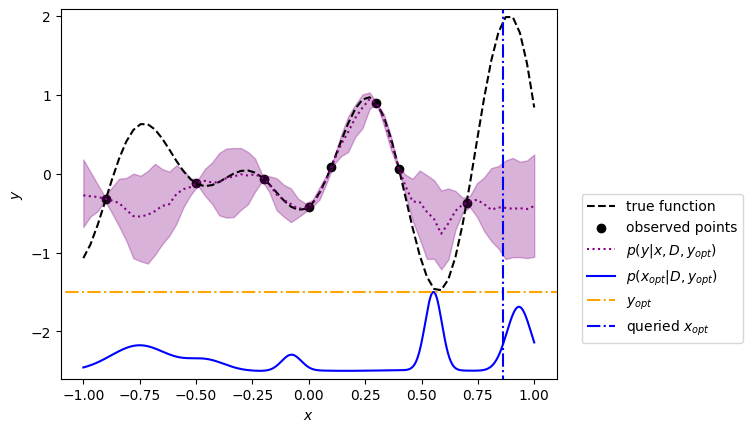

In [8]:
# get xopt sample after conditioning on yopt
xopt_idx = random.randint(0, 1000)
xopt = prediction_cond_yopt.samples[0, 0, xopt_idx]

plot_ace_bo_1d(
    x_true,
    f_true,
    data_autoreg_cond_yopt,
    prediction_cond_yopt,
    x_pdf_xopt_cond_yopt,
    pdf_xopt_cond_yopt,
    yopt=yopt_cond,
    xopt=xopt,
    ctx_data_idx_start=1,
    tar_data_idx_start=1,
)

#### <a id='toc1_4_1_3_'></a>[ACE-TS Usage](#toc0_)

This section shows how to run ACE-TS. First, ensure that `data_autoreg` is prepared as shown in the previous cell. With this setup, ACE can then be used as follows:

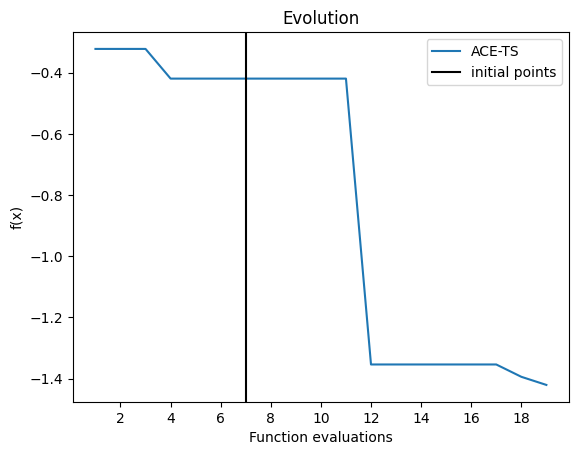

In [9]:
from src.bo.bayesian_optimizer import BayesianOptimizerACE
from src.bo.acquisition_rule.ace_thompson import ThompsonSamplingAcqRule

ace_ts = ThompsonSamplingAcqRule()

bo = BayesianOptimizerACE(objective_function, ace_model, rangex, ace_ts)
result = bo.optimize(data_autoreg, num_steps=10)

plt.title("Evolution")
plt.ylabel("f(x)")
plt.xlabel("Function evaluations")
evol_f = np.minimum.accumulate(result["batch"].yc[0, :, 0])
plt.plot(range(1, len(evol_f) + 1), evol_f, label="ACE-TS")
plt.axvline(n_initial - 1, label="initial points", color="black")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend()

## <a id='toc1_5_'></a>[ACE Min-Value Entropy Search (ACE-MES)](#toc0_)

In this section, we use ACE to perform Min-Value Entropy Search (MES) and visualize the process. For further details, refer to Appendix C.3.2 of the paper.

#### <a id='toc1_5_1_1_'></a>[ACE-MES visualization](#toc0_)

In [10]:
from src.bo.acquisition_rule.ace_mes import MinValueEntropySearchAcqRule


data_autoreg_mes = copy.deepcopy(data_autoreg)
n_cand = 100

x_cand = torch.linspace(-1, 1, n_cand).unsqueeze(-1).unsqueeze(-1)
ace_mes = MinValueEntropySearchAcqRule(n_cand_points=n_cand)
_, mes = ace_mes.sample(ace_model, data_autoreg_mes, xs=x_cand)
alpha = mes.detach().numpy()
xopt = np.linspace(-1, 1, n_cand)[alpha.argmax()]

Using the dataset defined above, we can visualize the MES landscape across a grid of 100 points. Note that in the figure below, the MES values are normalized for visualization purposes. 

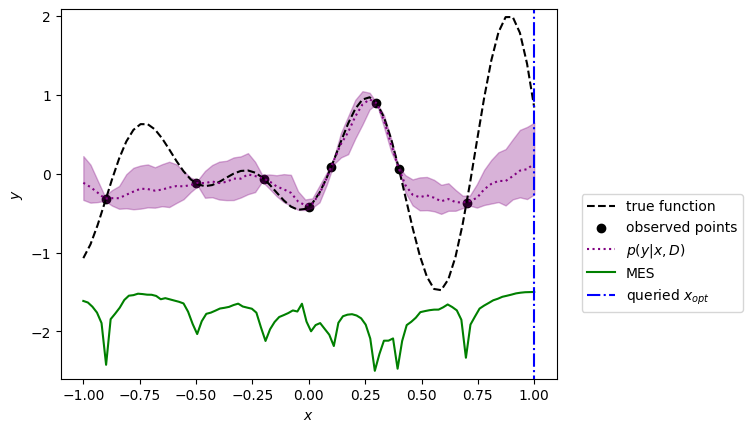

In [11]:
plot_ace_bo_1d(
    x_true,
    f_true,
    data_autoreg_mes,
    prediction,
    acq_values_x=np.linspace(-1, 1, n_cand),
    acq_values=alpha,
    xopt=xopt,
)

After querying the point, we evaluate it on the true function and then add it to the context set.

In [12]:
data_autoreg_mes.xc = torch.cat(
    (torch.Tensor([[[1, xopt]]]), data_autoreg_mes.xc), axis=1
)  
data_autoreg_mes.yc = torch.cat(
    (torch.Tensor([[[objective_function(xopt)]]]), data_autoreg_mes.yc), axis=1
)

Now, we repeat the same step with the updated context set and observe how the MES values change:

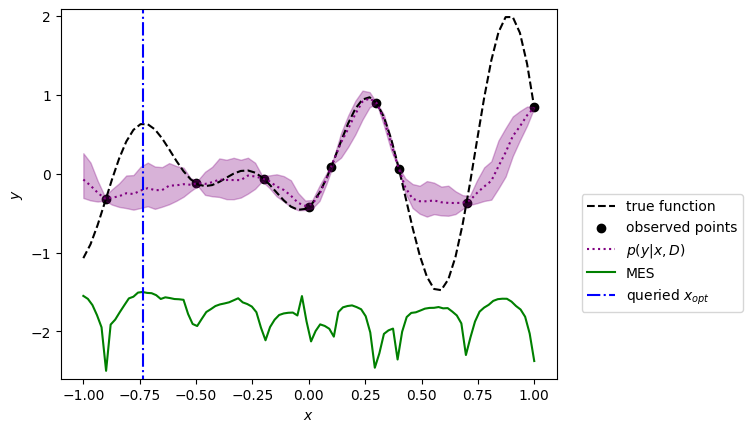

In [13]:
new_prediction = ace_model(data_autoreg_mes, predict=True)

_, mes = ace_mes.sample(ace_model, data_autoreg_mes, xs=x_cand)
alpha = mes.detach().numpy()
xopt = np.linspace(-1, 1, n_cand)[alpha.argmax()]

plot_ace_bo_1d(
    x_true,
    f_true,
    data_autoreg_mes,
    new_prediction,
    acq_values_x=np.linspace(-1, 1, n_cand),
    acq_values=alpha,
    xopt=xopt,
)

#### <a id='toc1_5_1_2_'></a>[ACE-MES Usage](#toc0_)

This section demonstrates how to run ACE-MES.

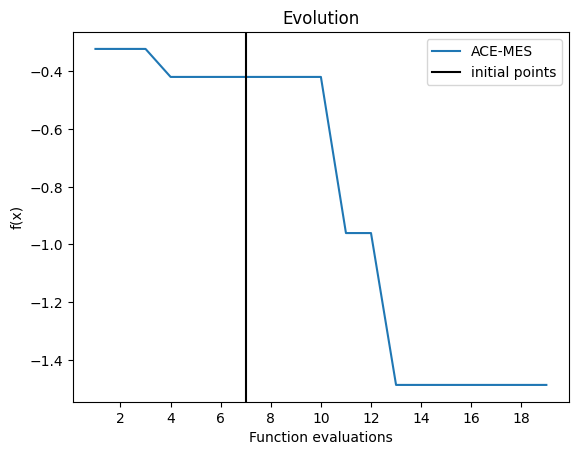

In [14]:
from src.bo.acquisition_rule.ace_mes import MinValueEntropySearchAcqRule

ace_mes = MinValueEntropySearchAcqRule()

bo = BayesianOptimizerACE(objective_function, ace_model, rangex, ace_mes)
result_ace_mes = bo.optimize(data_autoreg, num_steps=10)

plt.title("Evolution")
plt.ylabel("f(x)")
plt.xlabel("Function evaluations")
evol_f_ace_mes = np.minimum.accumulate(result_ace_mes["batch"].yc[0, :, 0])
plt.plot(range(1, len(evol_f_ace_mes) + 1), evol_f_ace_mes, label="ACE-MES")
plt.axvline(n_initial - 1, label="initial points", color="black")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend()

## <a id='toc1_6_'></a>[ACE-BO with Prior 1D](#toc0_)

ACE can also condition on prior information. In the case of BO, we place a prior on the location of $x_{opt}$.

#### <a id='toc1_6_1_1_'></a>[Model loading](#toc0_)

In [15]:
# Load model
acep_model_path = "./model/bo1d_pi/"
_, acep_model = load_config_and_model(acep_model_path, acep_model_path + ".hydra/")

### <a id='toc1_6_2_'></a>[ACE with Prior Thompson sampling (ACEP-TS)](#toc0_)

In the case of a prior over $x_{opt}$, we use Thompson sampling similar to the non-prior setting. With ACE, the prior can be seamlessly incorporated into the context set at test time.

#### <a id='toc1_6_2_1_'></a>[Flat prior](#toc0_)

In ACE, priors are defined using a binned distribution. Here, we show an example of a flat prior with 100 bins:

In [16]:
# set prior for xopt

bin_start_xopt = -1
bin_end_xopt = 1
num_bins = 100

x_bin_weights_xopt = np.linspace(bin_start_xopt, bin_end_xopt, 100)

# flat prior
bin_weights_flat = torch.ones((100)) / 100

Once the prior is defined, we add it to `latent_bin_weights` and set `bin_weights_mask` to `True`.

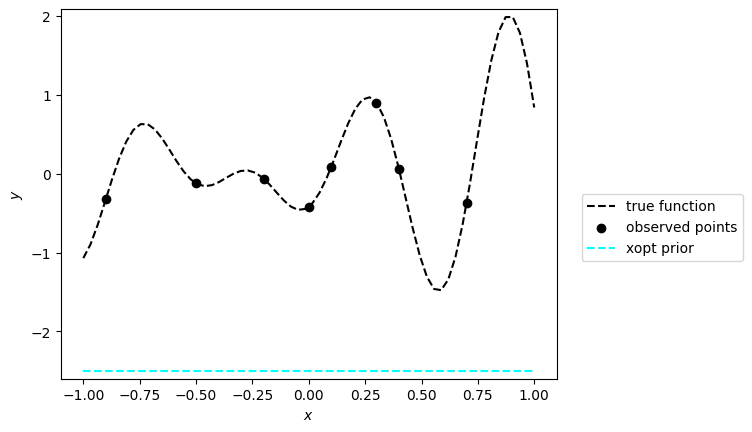

In [17]:
# Building the autoreg data with flat priors
data_autoreg_prior = copy.deepcopy(data_autoreg)
xc_shape = data_autoreg_prior.xc.shape
data_autoreg_prior.bin_weights_mask = torch.zeros(
    (xc_shape[0], xc_shape[1] + 1, 1), dtype=torch.bool
)
data_autoreg_prior.latent_bin_weights = torch.zeros(
    (xc_shape[0], xc_shape[1] + 1, num_bins)
)
data_autoreg_prior.xc = torch.cat(
    (torch.tensor([[[2.0, 0.0]]]), data_autoreg_prior.xc),
    axis=1,  # marker for xopt = 2
)
data_autoreg_prior.yc = torch.cat(
    (torch.tensor([[[0.0]]]), data_autoreg_prior.yc), axis=1
)
data_autoreg_prior.bin_weights_mask[:, 0, :] = torch.tensor([[True]])
data_autoreg_prior.latent_bin_weights[:, 0, :] = bin_weights_flat.unsqueeze(0)

plot_ace_bo_1d(
    x_true, f_true, data_autoreg_prior, xopt_prior=True, ctx_data_idx_start=1
)

Here we visualize the prediction of the data and the key latents on flat prior:

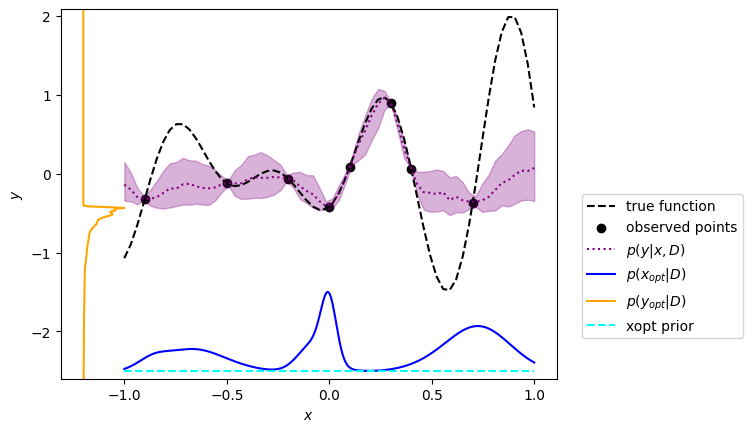

In [18]:
# flat prior plotting
pred = acep_model(data_autoreg_prior, predict=True)
x_pdf_xopt, pdf_xopt = get_mixture_pdf(
    pred.mixture_means[0, 0, :].detach().numpy(),
    pred.mixture_stds[0, 0, :].detach().numpy(),
    pred.mixture_weights[0, 0, :].detach().numpy(),
    x_range=[-1, 1],
)
x_pdf_yopt, pdf_yopt = get_mixture_pdf(
    pred.mixture_means[0, 1, :].detach().numpy(),
    pred.mixture_stds[0, 1, :].detach().numpy(),
    pred.mixture_weights[0, 1, :].detach().numpy(),
    x_range=[-5, 5],
)

plot_ace_bo_1d(
    x_true,
    f_true,
    data_autoreg_prior,
    pred,
    x_pdf_xopt,
    pdf_xopt,
    x_pdf_yopt,
    pdf_yopt,
    xopt_prior=True,
    ctx_data_idx_start=1,
)

#### <a id='toc1_6_2_2_'></a>[Gaussian prior](#toc0_)

Now, let’s use a more informative prior, specifically a Gaussian prior with a mean of $0.5$ and a standard deviation of $0.05$.

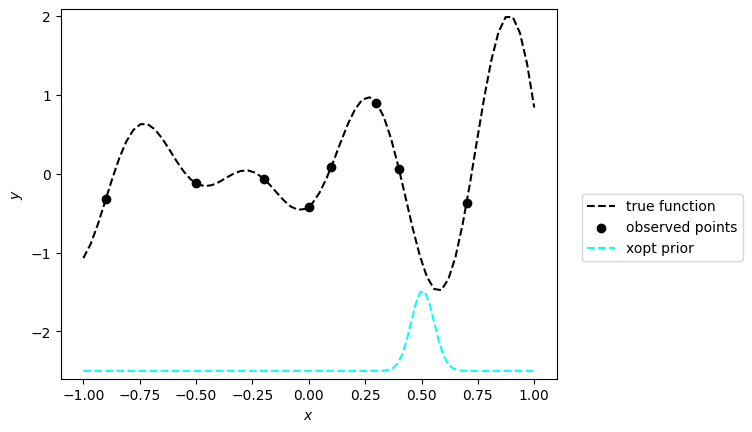

In [19]:
# set prior for xopt

prior_mean_xopt = 0.50
prior_std_xopt = 0.05

# gaussian prior
bin_weights_xopt = sample_gaussian_bin_weights(
    prior_mean_xopt, prior_std_xopt, bin_start_xopt, bin_end_xopt, num_bins
)
data_autoreg_prior.latent_bin_weights[:, 0, :] = bin_weights_xopt
plot_ace_bo_1d(
    x_true, f_true, data_autoreg_prior, xopt_prior=True, ctx_data_idx_start=1
)

By conditioning on this new prior, we observe that our $p(x_{opt}|D)$ is updated accordingly, reflecting the influence of the prior.

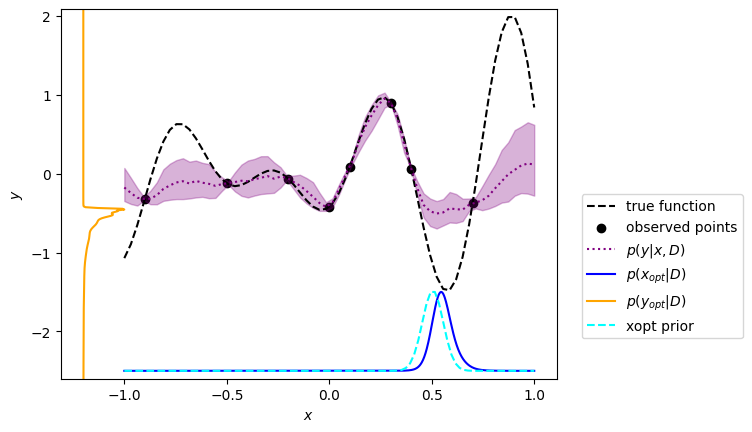

In [20]:
# prior plotting
pred = acep_model(data_autoreg_prior, predict=True)
x_pdf_xopt, pdf_xopt = get_mixture_pdf(
    pred.mixture_means[0, 0, :].detach().numpy(),
    pred.mixture_stds[0, 0, :].detach().numpy(),
    pred.mixture_weights[0, 0, :].detach().numpy(),
    x_range=[-1, 1],
)
x_pdf_yopt, pdf_yopt = get_mixture_pdf(
    pred.mixture_means[0, 1, :].detach().numpy(),
    pred.mixture_stds[0, 1, :].detach().numpy(),
    pred.mixture_weights[0, 1, :].detach().numpy(),
    x_range=[-5, 5],
)

plot_ace_bo_1d(
    x_true,
    f_true,
    data_autoreg_prior,
    pred,
    x_pdf_xopt,
    pdf_xopt,
    x_pdf_yopt,
    pdf_yopt,
    xopt_prior=True,
    ctx_data_idx_start=1,
)

### <a id='toc1_6_3_'></a>[ACEP-TS Usage](#toc0_)

Now, we can also run ACEP-TS in a similar way to ACE-TS and observe the improved performance on our predefined initial dataset*.

*Note: Performance may vary depending on the initial dataset.

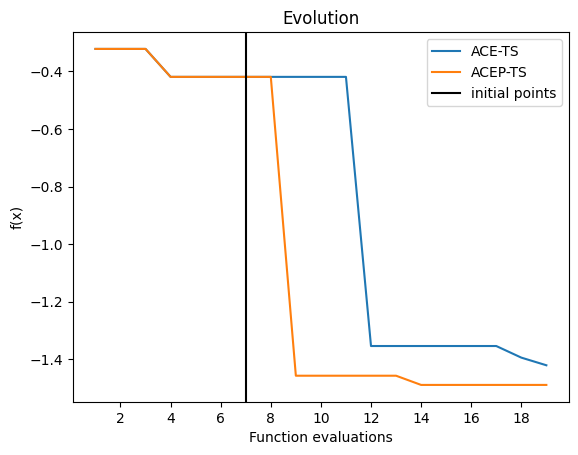

In [21]:
from src.bo.bayesian_optimizer import BayesianOptimizerACE
from src.bo.acquisition_rule.ace_thompson import ThompsonSamplingAcqRule

ace_ts = ThompsonSamplingAcqRule(prior=True)

bo = BayesianOptimizerACE(objective_function, acep_model, rangex, ace_ts)
result_ace_prior = bo.optimize(data_autoreg_prior, num_steps=10)

plt.title("Evolution")
plt.ylabel("f(x)")
plt.xlabel("Function evaluations")
plt.plot(range(1, len(evol_f) + 1), evol_f, label="ACE-TS")
evol_f_acep_ts = np.minimum.accumulate(result_ace_prior["batch"].yc[0, 1:, 0])
plt.plot(range(1, len(evol_f_acep_ts) + 1), evol_f_acep_ts, label="ACEP-TS")
plt.axvline(n_initial - 1, label="initial points", color="black")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend()